In [1]:
import pandas as pd
print "Pandas Version: ", pd.__version__
%pylab inline

Pandas Version:  0.16.2
Populating the interactive namespace from numpy and matplotlib


### Objetivo:

El Objetivo de este documento es hacer un análisis de los resultados provisorios de las Elecciones PASO Presidenciales en busca de posibles irregularidades en el proceso de conteo y carga de datos.

### Introducción

 - La base de datos fue obtenida a través del Grupo OpenDataCórdoba. Los datos venian en un archivo SQLite.
 - De la base de datos extraje 3 tablas:
  - NomPartidos: Para identificar los Partidos
  - MesasCandidaturasPresidente: Para extraer la cantidad de votos a presidente de cada partido. No está desglozado por candidato, sino por Frente/Alianza.
  - NomAmbitos: Para identificar a través de texto las localidades


### Read and Merge Data

In [2]:
nom_partidos = pd.read_csv('./data/NomPartidos', encoding='iso-8859-1')
mesas_presidente = pd.read_csv('./data/MesasCandidaturaPresidente', encoding='iso-8859-1')
nom_ambitos = pd.read_csv('./data/NomAmbitos', encoding='iso-8859-1')

nom_partidos.replace({'á': 'a','é': 'e','í': 'i','ó': 'o','ú': 'u'}, inplace=True, regex=True)
nom_ambitos.replace({'á': 'a','é': 'e','í': 'i','ó': 'o','ú': 'u'}, inplace=True, regex=True)

m1 = pd.merge(nom_partidos, mesas_presidente, left_on='parCodigo', right_on='vot_parCodigo')
votos_presidente_complete = pd.merge(m1, nom_ambitos, left_on=['vot_proCodigoProvincia','vot_depCodigoDepartamento'], right_on=['depCodigoProvincia', 'depCodigoDepartamento'])
votos_presidente_complete = pd.DataFrame(votos_presidente_complete)

columns = ['vot_proCodigoProvincia','depNombre', 'vot_munCodigoMunicipio', 'vot_mesCodigoCircuito', 'vot_mesCodigoMesa','parSiglas', 'vot_parCodigo', 'votVotosPartido']
votos_presidente = votos_presidente_complete[columns]

/home/patodb/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/home/patodb/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:3878: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  res = op(a, b)


### Busqueda de mesas con posibles errores.

##### Top N Mesas con mayor cantidad de votos

El primer criterio es buscar y checkear las mesas donde más votos se obtuvieron por partido. Sospecho que en donde más votos se sacaron, más posibilidades de sumar votos inexistentes había. Una vez identificadas, contrasté una por una en la página web www.resultados.gob.ar. Llegué a analizar las primeras 35 mesas, puede que hallan más.

In [49]:
cantidad_mesas = 35
top = votos_presidente.loc[votos_presidente.votVotosPartido.order(ascending=False).head(cantidad_mesas).index]

Resultados después de checkear a mano:
 - La mayoría de estas mesas presentan errores entre lo expresado en el Telegrama y lo Expresado en el sistema.
  - Hay errores de Data Entry, se confundían los 0 con 6. (Cabe recalcar que la escritura no era muy prolija aunque en la lógica general se entendía que ese número era imposible)
  - Hay errores donde el Total de Votos no coincide con los Registrados en la planilla.
  - Hay datos que no presetan incoherencia entre lo ingresado en el sitema y el telegrama enviado. No obstante, la cantidad de votos alta puede indicar que los datos pueden ser erroneos. Iguamente no tengo suficiente información para afirmar fraude y/o error.
 - En la Mayoria de las mesas donde la alianza UNA sacó muchos votos, la cantidad de votos asignada es en realidad (según el telegrama) la cantidad total de votos de la mesa. En Muchos casos, el telegrama no presenta nada escrito en los casilleros y sin embargo, en el sistema, se registró el total de votos de la Mesa, a dicho candidato (Ver Ejemplo 2, Ejemplo 3 y Ejemplo 4).
  - Ejemplo: Buenos Aires - Moreno- 663D - 00671
  - Ejemplo 2: Buenos Aires - Zarate - 1013 - 26
  - Ejemplo 3: Buenos Aires - La Plata - 0497 - 583
  - Ejemplo 4: Buenos Aires - La Matanza - 631D - 1251

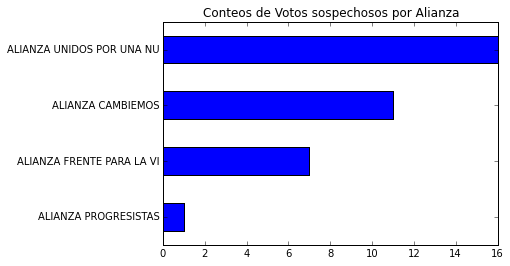

In [57]:
top.parSiglas.value_counts().order().plot(kind='barh', title="Conteos de Votos sospechosos por Alianza")

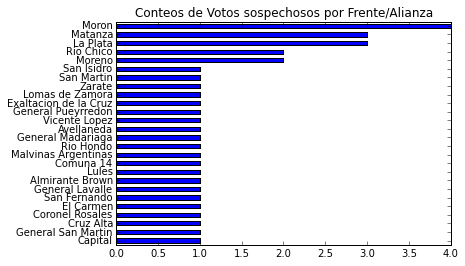

In [53]:
top.depNombre.value_counts().order().plot(kind='barh', title="Conteos de Votos sospechosos por Localidad")

In [58]:
top[["vot_proCodigoProvincia","depNombre", "vot_mesCodigoCircuito", "vot_mesCodigoMesa", "parSiglas", "votVotosPartido"]]

,vot_proCodigoProvincia,depNombre,vot_mesCodigoCircuito,vot_mesCodigoMesa,parSiglas,votVotosPartido
176302,2,General Madariaga,0340,18,ALIANZA PROGRESISTAS,805
231994,2,Matanza,0635E,2720,ALIANZA FRENTE PARA LA VI,793
394175,2,San Isidro,0892,398,ALIANZA CAMBIEMOS,757
188595,2,General Pueyrredon,0364,112,ALIANZA CAMBIEMOS,682
339617,2,Moron,0673,662,ALIANZA CAMBIEMOS,678
207739,2,General San Martin,0388,913,ALIANZA UNIDOS POR UNA NU,660
281272,2,La Plata,0496,391,ALIANZA UNIDOS POR UNA NU,657
91411,2,Almirante Brown,0021A,888,ALIANZA CAMBIEMOS,645
101578,2,Avellaneda,0030,184,ALIANZA CAMBIEMOS,644
704958,10,El Carmen,0031,821,ALIANZA CAMBIEMOS,386


##### Cantidad de Mesas con 0 votos registrados

In [4]:
print "Cant Mesas donde el FPV saco 0 votos: ", sum(votos_presidente[votos_presidente.parSiglas == "ALIANZA FRENTE PARA LA VI"].votVotosPartido == 0)
print "Cant Mesas donde Cambiemos saco 0 votos: ", sum(votos_presidente[votos_presidente.parSiglas == "ALIANZA CAMBIEMOS        "].votVotosPartido == 0)
print "Cant Mesas donde UNA saco 0 votos: ", sum(votos_presidente[votos_presidente.parSiglas == "ALIANZA UNIDOS POR UNA NU"].votVotosPartido == 0)

Cant Mesas donde el FPV saco 0 votos:  3697
Cant Mesas donde Cambiemos saco 0 votos:  3750
Cant Mesas donde UNA saco 0 votos:  4106


##### Listado de mesas donde hay 0 votos para esos partidos

In [57]:
mesas_sin_votos_fpv = votos_presidente[(votos_presidente.parSiglas == "ALIANZA FRENTE PARA LA VI") & (votos_presidente.votVotosPartido == 0)]
mesas_sin_votos_cambiemos = votos_presidente[(votos_presidente.parSiglas == "ALIANZA CAMBIEMOS        ") & (votos_presidente.votVotosPartido == 0)]
mesas_sin_votos_una = votos_presidente[(votos_presidente.parSiglas == "ALIANZA UNIDOS POR UNA NU") & (votos_presidente.votVotosPartido == 0)]